# Correlation CPM vs. M-model Reduced cost

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

In [2]:
import cobra
gem = cobra.io.load_json_model("./me_model_files/inputs/m_model.json")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-03


### Load predictions

In [3]:
fluxes = pandas.read_csv("./predictions/KT2440-MMODEL-M9.csv",index_col=0)

In [4]:
pred = pandas.Series({r.subsystem:0 for r in gem.reactions})
for r in gem.reactions:
    pred[r.subsystem] += fluxes["fluxes"].abs()[r.id]
pred.name = "predicted"

### Load omics data

In [5]:
rna = pandas.read_csv("./data-jul-2024/RNA-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [6]:
ribo = pandas.read_csv("./data-jul-2024/RS-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [7]:
samples = rna.columns.to_list()
rna_samples = [i + "_rna" for i in samples]
te_samples = [i + "_te" for i in samples]
all_samples = samples+rna_samples+te_samples+["predicted"]
colors = ["#2b83ba","#66bd63","#fdae61"]

### Load Annotation

In [8]:
Annotation = pandas.read_csv("./GeneAnnotation.csv",index_col=0)

In [9]:
Annotation

,locus_tag,name,description,type,length,subsystem
PP_0001,PP_RS00005,NaN,ParB/RepB/Spo0J family partition protein,CDS,873.0,NaN
PP_0002,PP_RS00010,NaN,ParA family protein,CDS,792.0,NaN
PP_0003,PP_RS00015,rsmG,16S rRNA (guanine(527)-N(7))-methyltransferase RsmG,CDS,651.0,Translation
PP_0004,PP_RS00020,mnmG,tRNA uridine-5-carboxymethylaminomethyl(34) synthesis enzyme MnmG,CDS,1893.0,NaN
PP_0005,PP_RS00025,mnmE,tRNA uridine-5-carboxymethylaminomethyl(34) synthesis GTPase MnmE,CDS,1371.0,NaN
...,...,...,...,...,...,...
PP_5418,PP_RS28235,atpE,F0F1 ATP synthase subunit C,CDS,258.0,Metabolic:S_Oxidative_Phosphorylation
PP_5419,PP_RS28240,atpB,F0F1 ATP synthase subunit A,CDS,870.0,Metabolic:S_Oxidative_Phosphorylation
PP_5420,PP_RS28245,NaN,F0F1 ATP synthase subunit I,CDS,408.0,Metabolic:S_Oxidative_Phosphorylation
PP_0688,NaN,NaN,NaN,NaN,NaN,Translation


In [10]:
pred = pred.rename({s:"Metabolic:"+s for s in pred.index if s not in Annotation["subsystem"]})

### Combine results

In [11]:
NormalizedRibo = ribo.div(ribo.sum())*1e6
NormalizedRNA = rna.div(rna.sum())*1e6
NormalizedTE = NormalizedRibo.div(NormalizedRNA,axis=0)
Results = NormalizedRibo.join(NormalizedRNA,rsuffix="_rna").join(NormalizedTE,rsuffix="_te")
ResultsAnnotated = pandas.concat([Results,Annotation],axis=1).loc[Results.index]
ResultsAnnotated.head()

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,PPutida_1_te,PPutida_2_te,PPutida_4_te,locus_tag,name,description,type,length,subsystem
PP_0001,115.346129,101.379836,117.392753,0.428368,1.142857,1.386889,269.268957,88.707377,84.644676,PP_RS00005,NaN,ParB/RepB/Spo0J family partition protein,CDS,873.0,NaN
PP_0010,649.987487,654.840617,574.275588,0.870122,2.032432,1.871958,747.007359,322.195592,306.777985,PP_RS00050,dnaA,chromosomal replication initiator protein DnaA,CDS,1521.0,NaN
PP_0097,20.691063,14.890996,21.743415,0.053546,0.358301,0.321102,386.416850,41.560009,67.714909,PP_RS00495,NaN,YheV family putative zinc ribbon protein,CDS,282.0,NaN
PP_0947,32.817598,33.777137,39.853891,0.087012,0.129730,0.136639,377.160906,260.365490,291.672262,PP_RS04975,NaN,ZIP family metal transporter,CDS,894.0,NaN
PP_0948,14.117067,14.164606,29.334633,0.046853,0.098842,0.109311,301.307316,143.306005,268.358322,PP_RS04980,NaN,HPr family phosphocarrier protein,CDS,273.0,NaN


###  Group by subsystem

In [25]:
ResultsGrouped = ResultsAnnotated[rna_samples+samples+["subsystem"]].groupby("subsystem").sum()
ResultsGrouped[te_samples] = ResultsGrouped[samples].div(ResultsGrouped[rna_samples].rename(columns={i:j for i,j in zip(rna_samples,samples)}),axis=1)

In [26]:
ResultsGrouped = pandas.concat([ResultsGrouped,pred],axis=1)

In [27]:
ResultsGrouped["predicted"] = ResultsGrouped["predicted"] + 1

In [28]:
ResultsGrouped.index.name = "subsystem"

In [29]:
# ResultsGrouped = ResultsAnnotated[~ResultsAnnotated["subsystem"].str.contains("S_Transport__Outer_Membrane")].groupby("subsystem").sum()

### Results

In [30]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

from scipy import stats
from scipy.stats import pearsonr

### Ribo

PearsonRResult(statistic=0.538006972635223, pvalue=9.2590379376056e-21)


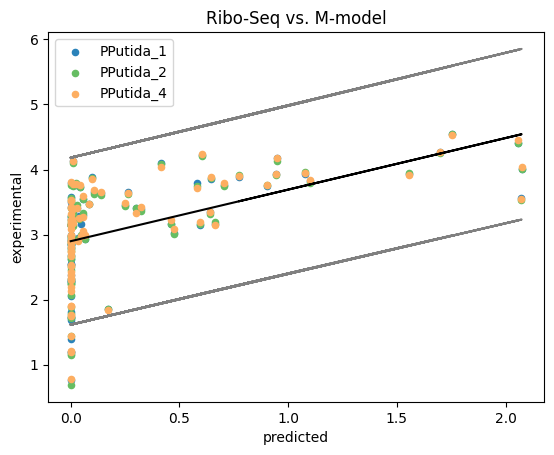

In [31]:
slist = samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
# colors = ["brown","blue","green"]
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("Ribo-Seq vs. M-model")

plt.savefig("./figures/riboseq-cpm-bysubsystem-performance-m.svg",format="svg")

In [32]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.to_csv("./datasets/performance/ribo-mmodel.csv")
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,0.766461,1.613506,4.181794,2.89765,0.0
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,0.687245,1.613506,4.181794,2.89765,0.0
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_4,0.779506,1.613506,4.181794,2.89765,0.0
Metabolic:Murein Recycling,PPutida_1,2.292811,1.613506,4.181794,2.89765,0.0
Metabolic:Murein Recycling,PPutida_2,2.249153,1.613506,4.181794,2.89765,0.0


### RNA

PearsonRResult(statistic=0.5418060268432099, pvalue=4.3824509122289135e-21)


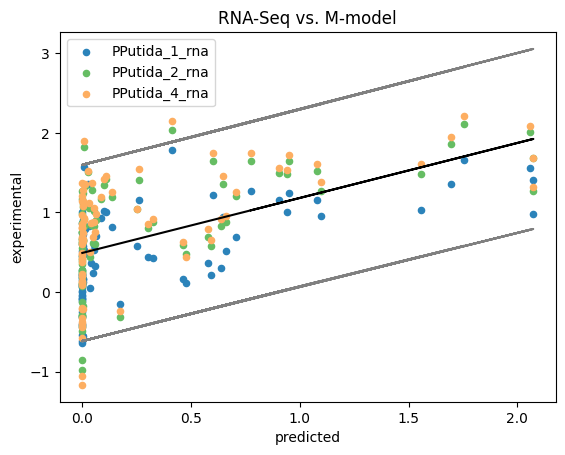

In [33]:
slist = rna_samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("RNA-Seq vs. M-model")

plt.savefig("./figures/rnaseq-cpm-bysubsystem-performance-m.svg",format="svg")

In [34]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.to_csv("./datasets/performance/rna-mmodel.csv")
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,-0.540895,-0.614269,1.598796,0.492264,0.0
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,-0.978731,-0.614269,1.598796,0.492264,0.0
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_4,-1.165454,-0.614269,1.598796,0.492264,0.0
Metabolic:Murein Recycling,PPutida_1,-0.077453,-0.614269,1.598796,0.492264,0.0
Metabolic:Murein Recycling,PPutida_2,0.245665,-0.614269,1.598796,0.492264,0.0


### TE

PearsonRResult(statistic=0.1704651405344226, pvalue=0.006052955245809769)


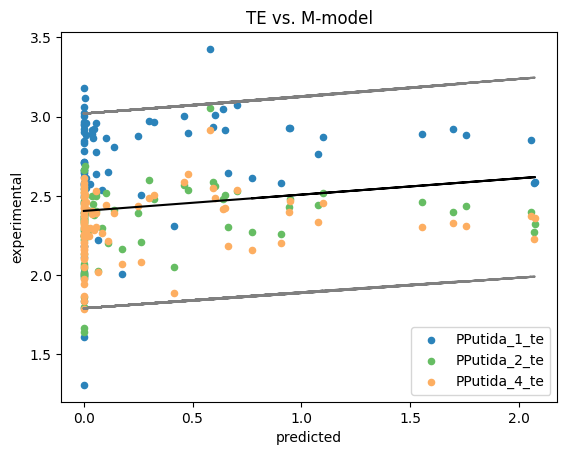

In [35]:
slist = te_samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("TE vs. M-model")

plt.savefig("./figures/te-cpm-bysubsystem-performance-m.svg",format="svg")

In [36]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.to_csv("./datasets/performance/te-mmodel.csv")
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,1.307355,1.790859,3.019913,2.405386,0.0
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,1.665976,1.790859,3.019913,2.405386,0.0
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_4,1.944961,1.790859,3.019913,2.405386,0.0
Metabolic:Murein Recycling,PPutida_1,2.370265,1.790859,3.019913,2.405386,0.0
Metabolic:Murein Recycling,PPutida_2,2.003488,1.790859,3.019913,2.405386,0.0
